In [301]:
from __future__ import annotations

import json
import os
from pathlib import Path
from queue import Queue

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from librosa import load, feature
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

PATH_TO_FILES = Path('files/')

In [302]:
class FileFinder:
    suffixes: set[str]
    _queue: Queue[Path]

    def __init__(self, root, suffixes):
        self.root = Path(root)
        self._queue = Queue()
        self.suffixes = suffixes

        self._queue.put(self.root)

    def get_next_file(self):
        if self._queue.empty():
            print("Queue is empty")
            return None

        res = self._queue.get()
        if res.is_dir():
            for child in res.iterdir():
                if child.suffix[1:].lower() in self.suffixes or child.is_dir():
                    # print(f'Added {child.name} to queue [{"folder" if child.is_dir() else child.suffix}]')
                    self._queue.put(child)
            return Ellipsis
        else:
            return res if res.suffix[1:] in self.suffixes else None

    def reset(self):
        self._queue = Queue()
        self._queue.put(self.root)

    def get_rel_path(self, file: Path):
        return Path(os.path.relpath(file.parent, self.root).__str__())

    def get_full_path(self, file: Path):
        return self.root.joinpath(file)

class FileIO:
    _data: list[dict, ...]

    def __init__(self, path):
        self.path = Path(path)
        self._data = ...
    
    def get_data(self):
        with open(self.path) as json_file:
            self._data = json.load(json_file)
        return self._data
    
    def set_data(self, data):
        if type(data) is list:
            self._data = data
            with open(self.path, 'w') as json_file:
                json_file.write(json.dumps(self._data, sort_keys=False, indent=4))
        

In [303]:
#TODO: standardize/normalize features

class FeatureExtractor:
    def __init__(self):
        self.mfccs = 13
        self.rate = 22050
    
    def not_static(self):
        """
        Method to ensure all the methods cannot be static.
        """
        pass
    
    def tempo(self, audio):
        return np.mean(feature.tempo(y=audio, sr=self.rate).tolist())
    
    def rms(self, audio):
        self.not_static()
        return np.mean(feature.rms(y=audio).tolist())
    
    def mfcc(self, audio):
        return np.mean(feature.mfcc(y=audio, sr=self.rate, n_mfcc=self.mfccs).tolist(), axis=1)
    
    def bandwidth(self, audio):
        return np.mean(feature.spectral_bandwidth(y=audio, sr=self.rate).tolist())
    
    def centroid(self, audio):
        return np.mean(feature.spectral_centroid(y=audio, sr=self.rate).tolist())
    
    def contrast(self, audio):
        return np.mean(feature.spectral_contrast(y=audio, sr=self.rate).tolist())
    
    def rolloff(self, audio):
        return np.mean(feature.spectral_rolloff(y=audio, sr=self.rate).tolist())
    
    def zcr(self, audio):
        self.not_static()
        return np.mean(feature.zero_crossing_rate(y=audio).tolist())
    

In [304]:
class Model:
    def __init__(self, dt: list, features):
        self.dt = dt
        self.df = pd.DataFrame(dt)
        self.features = features
        self.categories = self.df[['genre']]
        self.predictors = self.df[features]
        self.predictors.columns = features
        self.model = ...
        self.split_data = ...
        self.res = ...
    
    def update_dataframe(self, df):
        self.df = df
    
    def generate_model(self, test_size=0.33, solver='newton-cg', iters=1000):
        self.split_data = train_test_split(self.predictors, self.categories, test_size=test_size, random_state=5)
        pre_train, pre_test, cat_train, cat_test = self.split_data
        self.model = LogisticRegression(multi_class='multinomial', solver=solver, max_iter=iters)
        self.model.fit(pre_train, cat_train.genre)
        self.res = self.model.predict(pre_test)
        
    def get_res(self):
        return self.res
    
    def get_matrix(self):
        return confusion_matrix(self.split_data[3], self.res)
    
    def get_report(self):
        return classification_report(self.split_data[3], self.res)

In [305]:
def get_heatmap(matrix):
    #Visualize Confusion Matrix
    confusion_matrix_data = matrix

    # Genre labels
    labels = ['Classical', 'HipHop', 'Jazz', 'Pop', 'Reggae']

    # Create a figure and a set of subplots
    fig, ax = plt.subplots()

    # Create the heatmap
    cax = ax.matshow(confusion_matrix_data, cmap=plt.cm.Blues)

    # Add color bar
    fig.colorbar(cax)

    # Set the locations and labels of the ticks (small lines under axes)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels)

    # Set axis titles
    ax.set_xlabel('True Genre')
    ax.set_ylabel('Predicted Genre')

    # Loop over the actual confusion matrix to get the values and format them into the heatmap.
    for (i, j), val in np.ndenumerate(confusion_matrix_data):
        ax.text(j, i, val, ha='center', va='center', 
            color='white' if val > np.max(confusion_matrix_data)/2 else 'black')

    plt.show()


In [306]:
def box_mfcc(df):
    #Determine the feature columns 
    non_mfcc_columns = [col for col in df.columns if 'mfcc' not in col]
    
    #Drop out the feature columns 
    df_only_mfccs = df.drop(non_mfcc_columns, axis=1)

    plt.figure(figsize=(12, 6))
    plt.title('Distribution of MFCC Coefficients')
    plt.ylabel('Coefficient Value')
    df_only_mfccs.boxplot()
    plt.show()
    
def box_features(df):
    #Determine the MFCC columns 
    mfcc_columns = [col for col in df.columns if 'mfcc' in col]
    
    #Drop out the MFCC columns 
    df_only_features = df.drop(mfcc_columns, axis=1)

    plt.figure(figsize=(12, 6))
    plt.title('Distribution of Feature Coefficients')
    plt.ylabel('Coefficient Value')
    df_only_features.boxplot()
    plt.show()
    

In [307]:
### ONLY RUN THIS CELL TO EXTRACT FEATURES
DATA = []
if input():
    finder = FileFinder(PATH_TO_FILES, ('au', ))
    output = FileIO('data.json')
    extractor = FeatureExtractor()
    
    while True:
        curr = finder.get_next_file()
        if not curr:
            break
        elif curr is ...:
            continue
        else:
            curr_file, fs = load(curr, duration=7, sr=extractor.rate)
            DATA.append(dict(
                id=curr.name,
                genre=curr.parent.name,
                **dict(zip((f'mfcc{n}' for n in range(extractor.mfccs)), extractor.mfcc(curr_file))),
                tempo=extractor.tempo(curr_file),
                rms=extractor.rms(curr_file),
                bandwidth=extractor.bandwidth(curr_file),
                centroid=extractor.centroid(curr_file),
                contrast=extractor.contrast(curr_file),
                rolloff=extractor.rolloff(curr_file),
                zcr=extractor.zcr(curr_file),
                prediction=''
            ))
            # print(curr.parent.name, curr.name.split('.')[1])
    
    output.set_data(DATA)
    print('Success')

In [308]:
### OLD CODE

# test_features = [*(f'mfcc{n}' for n in range(extractor.mfccs // 2)), 'zcr']
# 
# frame = pd.DataFrame(data)
# categories = frame[['genre']]
# predictors = frame[test_features]
# predictors.columns = test_features
# 
# pre_train, pre_test, cat_train, cat_test = train_test_split(predictors, categories, test_size=0.33, random_state=5)
# model = LogisticRegression(multi_class='multinomial', solver='newton-cg', max_iter=1000)
# model.fit(pre_train, cat_train.genre)
# predictions = model.predict(pre_test)
# print(confusion_matrix(cat_test, predictions))
# print(classification_report(cat_test, predictions))

In [309]:
### RUN THIS CELL TO GET THE DATA WITHOUT RE-EXTRACTING THE FEATURES 
DATA = FileIO('data.json').get_data()

              precision    recall  f1-score   support

   classical       0.82      0.82      0.82        11
      hiphop       0.57      0.40      0.47        20
        jazz       0.58      0.94      0.71        16
         pop       0.59      0.81      0.68        16
      reggae       0.70      0.35      0.47        20

    accuracy                           0.63        83
   macro avg       0.65      0.66      0.63        83
weighted avg       0.64      0.63      0.60        83



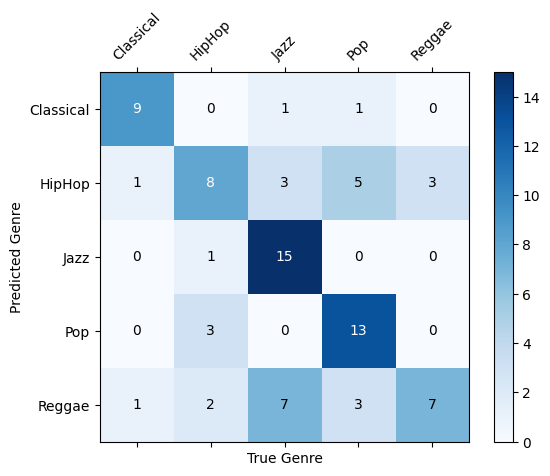

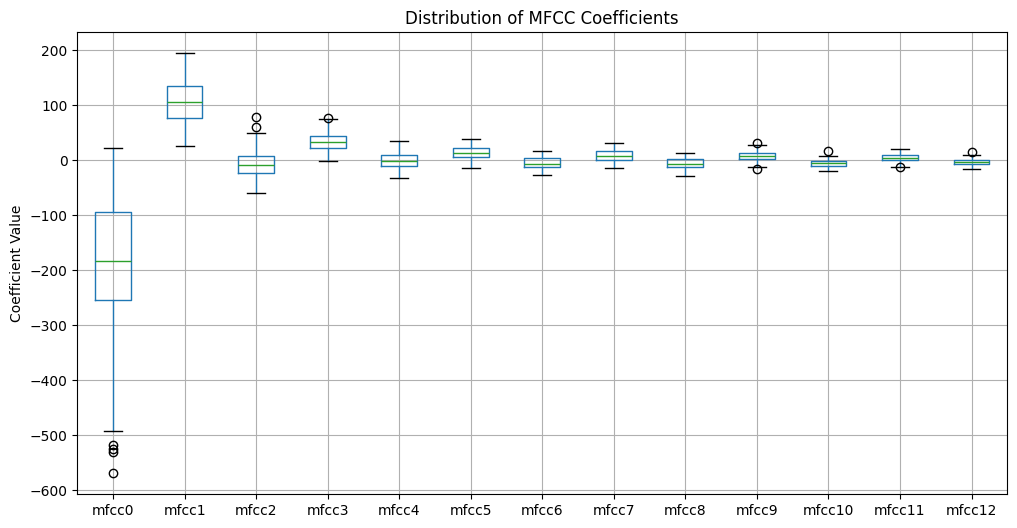

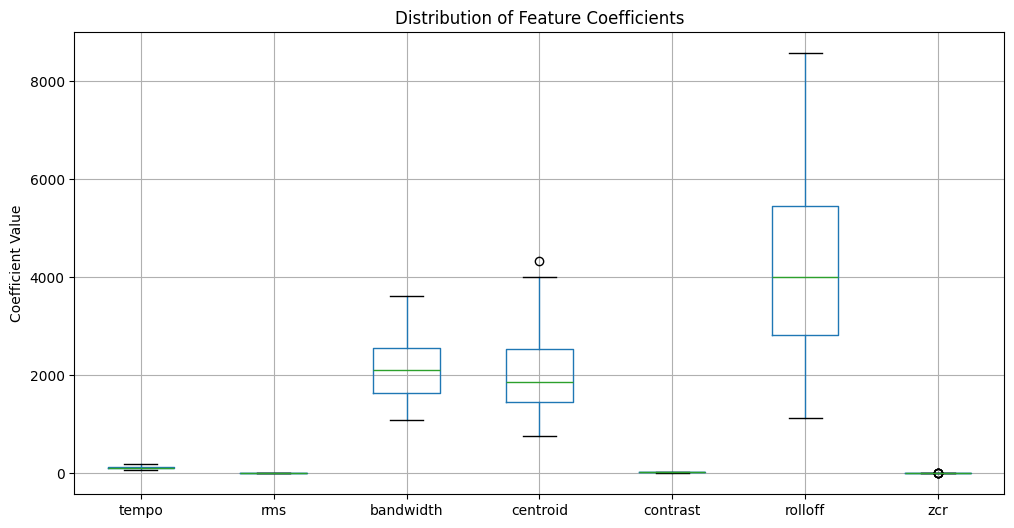

In [310]:
### EXAMPLE MODEL



# Change the list in this constructor to change the features analyzed (names must match JSON file)
m1 = Model(DATA,
           [*(f'mfcc{n}' for n in range(10)), 
            'contrast',
            'zcr']
           )

# Add parameters to change model functionality
m1.generate_model()

print(m1.get_report())
get_heatmap(m1.get_matrix())

box_mfcc(m1.df)
box_features(m1.df)